# Data Import
***
Here we import telecom data set, which has information about users and whether they left the company (Churn)

***
Import and take a look at the data

In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('Data-Mining-Project/data/train.csv')
train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


***
Check for missing values and delete them

In [2]:
init_len = len(train)
print(train.isna().sum())
train = train.dropna()
# test = test.dropna()
print(f"\nData left: {len(train)}/{init_len}")

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

Data left: 5282/5282


In [3]:
mask = train['TotalSpent'] == ' '
train.loc[mask, 'TotalSpent'] = train.loc[mask, 'MonthlySpending'].astype('string')

In [4]:
print(train.TotalSpent.dtype) # not good
print(train.TotalSpent.sort_values(ascending=True).values)
mask = train['TotalSpent'] == ' '
# train.TotalSpent = train.TotalSpent.replace(' ', 1) 

train.TotalSpent = train.TotalSpent.astype(float)

object
['100.2' '100.25' '100.35' ... '997.65' '998.1' '999.9']


# Exploratory Data Analysis
***
Here we perform:
1. See variable distributions.
2. Encode variables.
3. Correlations between variables.
<br> <br>

From this section we conclude:
1. Class disbalance can be seen
2. People with month-to-month contract are tend to leave the company.
3. People with highest client period are most loyal and hence less likely to leave the company.
4. Numerical features such as ClientPeriod, MonthlySpending, TotalSpent are significant to analysis.
5. By building Decision Treee, We can deduce several main rules when determining the Churn of users.

***
<div class="alert alert-block alert-info">
Class disbalance can be seen in data. That means balancing methods could improve model performance
</div>

In [5]:
cat_cols = []
bin_cols = []
num_cols = []
for col in train.columns.tolist():
    if len(train[col].value_counts()) > 2 and len(train[col].value_counts())<10:
        cat_cols.append(col)
    elif len(train[col].value_counts()) == 2:
        bin_cols.append(col)
    else:
        num_cols.append(col)

In [6]:
import matplotlib.pyplot as plt

# Print target class value counts
print(f"Target class value counts: \n{train['Churn'].value_counts()}")


Target class value counts: 
0    3898
1    1384
Name: Churn, dtype: int64


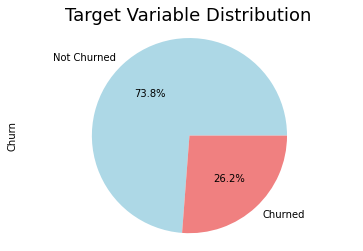

In [7]:
plt.title("Target Variable Distribution", fontsize=18)
train['Churn'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Not Churned', 'Churned'], colors=['lightblue', 'lightcoral'])
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
plt.show()

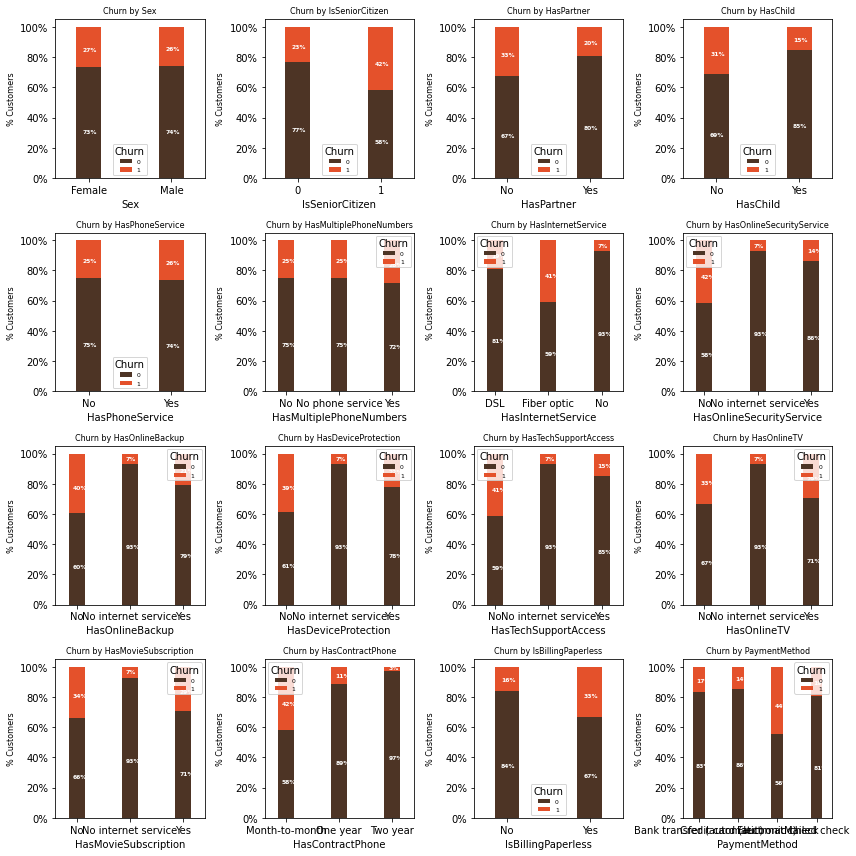

In [8]:
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

def plot_categorical_feature_with_churn(data, feature, ax):
    colors = ['#4D3425', '#E4512B']
    churn_data = data.groupby([feature, 'Churn']).size().unstack()

    (churn_data.T * 100.0 / churn_data.T.sum()).T.plot(
        kind='bar', 
        width=0.3, 
        stacked=True, 
        rot=0, 
        ax=ax, 
        color=colors
    )
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.legend(loc='best', prop={'size': 6}, title='Churn')
    ax.set_ylabel('% Customers', size=8)
    ax.set_title(f'Churn by {feature}', size=8)

    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.0f}%'.format(height), (p.get_x() + .25 * width, p.get_y() + .4 * height),
                    color='white',
                    weight='bold',
                    size=6)

# Create subplots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
features = [
    'Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild',
    'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService',
    'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV',
    'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod'
]

# Plot each feature on its respective subplot
for i, feature in enumerate(features):
    row, col = i // 4, i % 4
    plot_categorical_feature_with_churn(train, feature, axes[row, col])

plt.tight_layout()
plt.show()

***
Find numerical, categorical and binary variables in data

In [9]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


encoder = LabelEncoder()
train[bin_cols] = train[bin_cols].apply(LabelEncoder().fit_transform)
train = pd.concat((train[bin_cols + num_cols], pd.get_dummies(train[cat_cols])), axis=1)


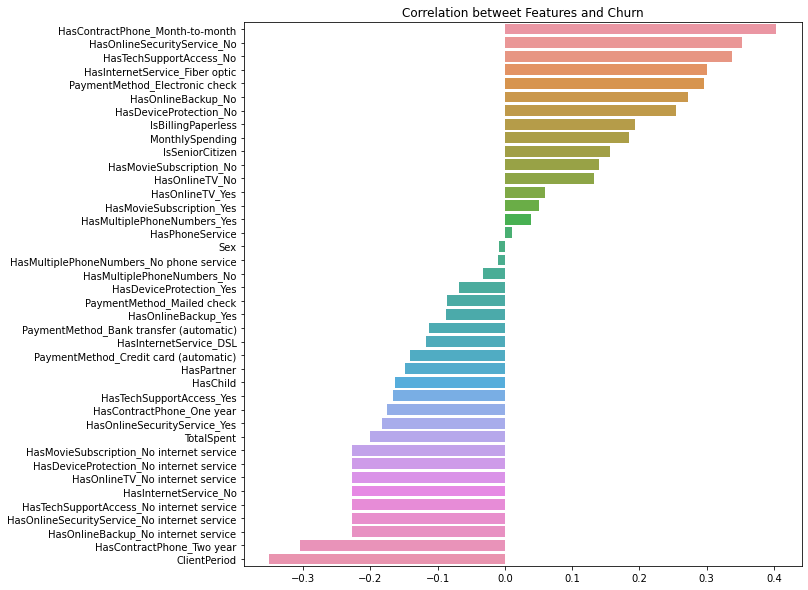

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(1, figsize=(10, 10))
q = pd.DataFrame(train.drop(columns=['Churn']).corrwith(train['Churn']).sort_values(ascending=False)).transpose()
sns.barplot(data=q, orient='h')
ax.set(title='Correlation betweet Features and Churn');

***
Perform Mann Whitney test to check if numerical values affect Churn distribution

H0 - Data is retrieved from same distribution, no difference between churn / non-churn users -> variables are useless in analysis

In [11]:
from scipy.stats import mannwhitneyu

isgone = train[train['Churn'] == 1]
ishere = train[train['Churn'] == 0]

# H0 - Data is retrieved from same distribution, no difference between churn / non-churn users -> variables are useless in analysis
for i, cat in enumerate(num_cols):
    p = mannwhitneyu(isgone[cat], ishere[cat]).pvalue
    print(f'p-value for feature {cat} is {p}, should we reject H0? - {["NO", "YES"][bool(p < 0.01)]}') #без bool выходит предупреждение

p-value for feature ClientPeriod is 3.0185665779997006e-155, should we reject H0? - YES
p-value for feature MonthlySpending is 8.486407520895914e-37, should we reject H0? - YES
p-value for feature TotalSpent is 3.745320445096567e-63, should we reject H0? - YES


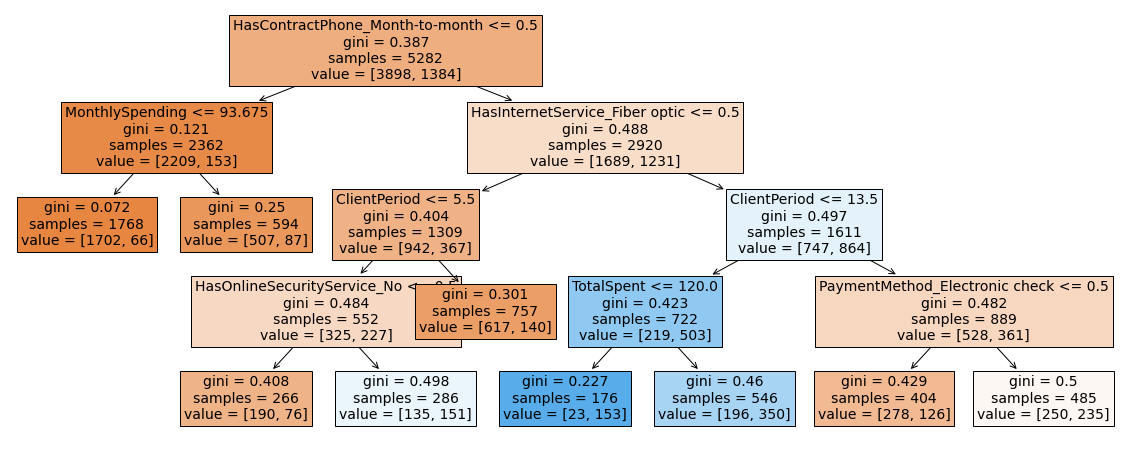

In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(min_impurity_decrease=0.002)
clf.fit(train.drop(columns=['Churn']), train['Churn'])
plt.figure(figsize=(20, 8))
plot_tree(clf, fontsize=14, feature_names=train.drop(columns=['Churn']).columns, filled=True)
plt.show()

Feature selection based on random forest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

PARAMS = {
    "min_samples_split": [9],  # range(2, 200),
    "min_samples_leaf": [19],  # range(1, 200),
}
clf = RandomForestClassifier(n_estimators=200, random_state=42)

grid_search = GridSearchCV(clf, PARAMS, scoring="roc_auc", cv=5)
rf = grid_search.fit(train.drop(columns=['Churn']), train['Churn']);

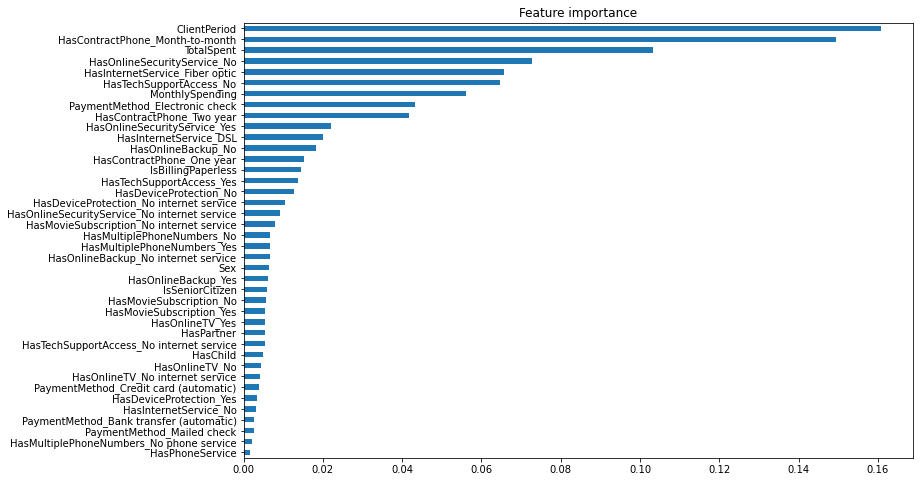

In [14]:
pd.DataFrame(rf.best_estimator_.feature_importances_, index=train.drop(columns=['Churn']).columns, columns=["importance"]) \
    .sort_values("importance") \
    .plot(kind="barh", legend=False, figsize=(12, 8));
plt.title("Feature importance");

In [15]:
feature_eng = pd.DataFrame(rf.best_estimator_.feature_importances_, index=train.drop(columns=['Churn']).columns, columns=["importance"])
feature_list = feature_eng[feature_eng['importance'] > 0.025].index.to_list()
feature_list += ['Churn']
train = train[feature_list]
feature_list

['ClientPeriod',
 'MonthlySpending',
 'TotalSpent',
 'HasInternetService_Fiber optic',
 'HasOnlineSecurityService_No',
 'HasTechSupportAccess_No',
 'HasContractPhone_Month-to-month',
 'HasContractPhone_Two year',
 'PaymentMethod_Electronic check',
 'Churn']

# Preprocessing

***
In this section we perform:
1. Over sampling.
2. Train-Test split.
3. Normalization. Standard Scaler

Label and OneHot encoding are done in previous section, to permorm EDA on these variables.

In [16]:
from imblearn.over_sampling import SMOTE
import numpy as np

def undersample(df):
    class_0 = df[df['Churn'] == 0].sample(1106)
    class_1 = df[df['Churn'] == 1]
    return pd.concat([class_0, class_1], axis=0)

def oversample(df):
    class_0 = df[df['Churn'] == 0]
    class_1 = df[df['Churn'] == 1].sample(3111, replace=True)
    return pd.concat([class_0, class_1], axis=0)




train = oversample(train)
# train

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(train.drop(columns=['Churn']), train['Churn'], test_size=.25, random_state=777)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])

# Train Models
***
In this section we:
1. Train models such as: LogRegression, KNN, GradientBoosting, RandomForest
2. Use RandomForest to retrieve feature importances.

## Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score

Cs = np.logspace(-3, 1, 30)
# Cs = np.arange(0, 10)

logcv = LogisticRegressionCV(Cs=Cs, random_state=123, scoring='roc_auc')
logcv.fit(X_train, y_train)
best_C = logcv.C_[0]

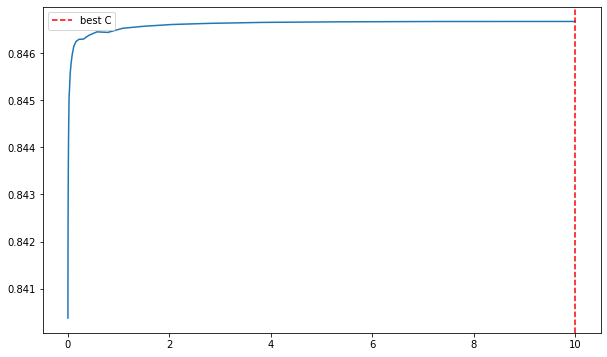

In [20]:
plt.figure(figsize=(10, 6))
sns.lineplot(y=logcv.scores_[1].mean(axis=0), x=logcv.Cs_)
plt.axvline(logcv.C_, ls='--', color='r', label='best C')
plt.legend()

In [21]:
y_train_predicted = logcv.predict_proba(X_train)[:, 1]
# y_test_predicted = logcv.predict_proba(X_val[feature_list])[:, 1]
y_test_predicted = logcv.predict_proba(X_val)[:, 1]

In [22]:
# roc_auc_score(y_val, logcv.predict_proba(X_val[feature_list])[:, 1])
roc_auc_score(y_val, logcv.predict_proba(X_val)[:, 1])

0.8417471772020453

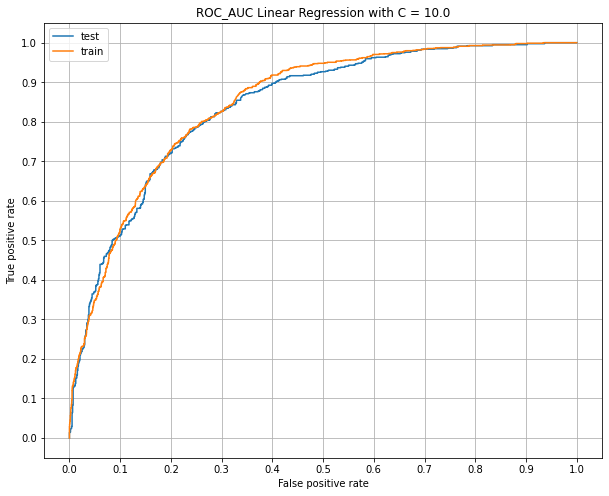

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(*roc_curve(y_val, y_test_predicted)[:2], label='test')
ax.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train')
ax.legend()
ax.set(xlabel='False positive rate', ylabel='True positive rate', title=f'ROC_AUC Linear Regression with C = {round(best_C, 5)}')
ax.grid()
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xticks(np.linspace(0, 1, 11));

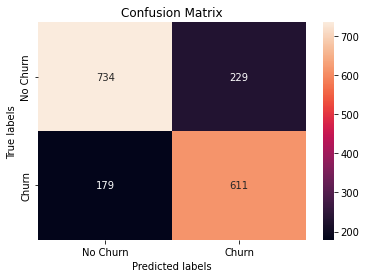

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix

y_test_predicted = logcv.predict(X_val)
cm = confusion_matrix(y_val, y_test_predicted)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

In [25]:
roc_auc_score(y_val, logcv.predict_proba(X_val)[:, 1])

0.8417471772020453

## KNN

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

neigh = KNeighborsClassifier()
# parameters = {'n_neighbors': [i for i in range(4, 12)],
#              'metric': ['manhattan'],
#              }

parameters = {'n_neighbors': [i for i in range(5, 15)],
             'metric': ['manhattan'],
             }

grid_search = GridSearchCV(estimator=neigh, param_grid=parameters, cv=10, refit=True, scoring="roc_auc", n_jobs=-1,)
knn = grid_search.fit(X_train, y_train)

In [27]:
print(f"best score: {knn.best_score_}")
print(f"best params: {knn.best_params_}")

best score: 0.854765780565876
best params: {'metric': 'manhattan', 'n_neighbors': 5}


In [28]:
roc_auc_score(y_val, knn.predict_proba(X_val)[:, 1])

0.8450944437872155

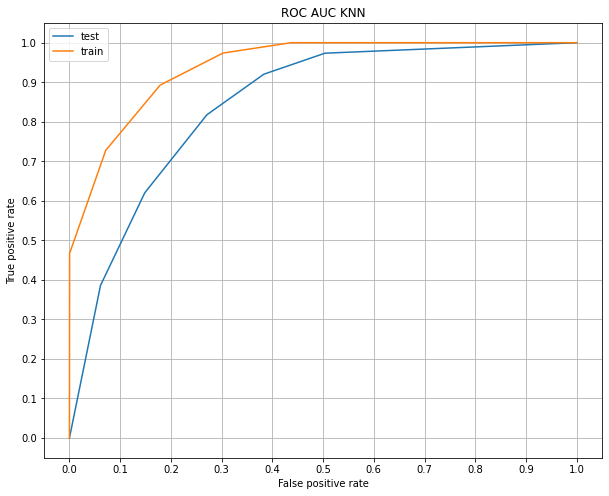

In [29]:
y_train_predicted = knn.predict_proba(X_train)[:, 1]
y_test_predicted = knn.predict_proba(X_val)[:, 1]

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(*roc_curve(y_val, y_test_predicted)[:2], label='test')
ax.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train')
ax.legend()
ax.set(xlabel='False positive rate', ylabel='True positive rate', title=f'ROC AUC KNN')
ax.grid()
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xticks(np.linspace(0, 1, 11));

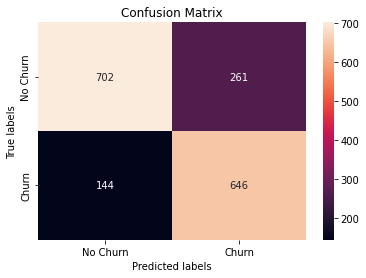

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix

y_test_predicted = knn.predict(X_val)
cm = confusion_matrix(y_val, y_test_predicted)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

## Gradient boosting

In [31]:
from catboost import CatBoostClassifier

catboost = CatBoostClassifier(
    cat_features=X_train.nunique()[X_train.nunique() == 2].index.tolist(),
    logging_level="Silent",
    eval_metric="AUC:hints=skip_train~false",
    grow_policy="Lossguide",
    metric_period=1000,
    random_seed=42,
    loss_function='CrossEntropy',
#     task_type='GPU',
    early_stopping_rounds=10
)

PARAMS = {
    "n_estimators": [300, 500, 700, 1000],  # [5, 10, 20, 30, 40, 50, 70, 100, 150, 200, 250, 300, 500, 1000],
    "learning_rate": [0.05],  # [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5],
    "max_depth": [4],  # np.arange(4, 20, 1),
    "l2_leaf_reg": [10],  # np.arange(0.1, 1, 0.05),
    "subsample": [0.6],  # [3, 5, 7, 10],
#     "random_strength": [2, 5, 8],  # [1, 2, 5, 10, 20, 50, 100],
    "min_data_in_leaf": [100],  # np.arange(10, 1001, 10),
#     'task_type': ['GPU'],
#     'early_stopping_rounds': [10],
}
catboost.grid_search(PARAMS, X_train, y_train, cv=5, plot=True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 0.8537448	best: 0.8537448 (0)	total: 223ms	remaining: 669ms
1:	loss: 0.8537448	best: 0.8537448 (0)	total: 347ms	remaining: 347ms


2:	loss: 0.8537448	best: 0.8537448 (0)	total: 482ms	remaining: 161ms
3:	loss: 0.8537448	best: 0.8537448 (0)	total: 603ms	remaining: 0us
Estimating final quality...


{'params': {'min_data_in_leaf': 100,
  'depth': 4,
  'l2_leaf_reg': 10,
  'iterations': 300,
  'subsample': 0.6,
  'learning_rate': 0.05},
 'cv_results': defaultdict(list,
             {'iterations': [0, 102],
              'test-AUC-mean': [0.8261193518942154, 0.8333306350800562],
              'test-AUC-std': [0.012808073347566442, 0.021543910412352804],
              'train-AUC-mean': [0.8281996652941992, nan],
              'train-AUC-std': [0.004770122418632079, nan],
              'test-CrossEntropy-mean': [0.6710059002952709, nan],
              'test-CrossEntropy-std': [0.0010134308258643238, nan],
              'train-CrossEntropy-mean': [0.6707701749739966, nan],
              'train-CrossEntropy-std': [0.0008035405465543179, nan]})}

In [32]:
print("Best score:", end=' ')
print(catboost.best_score_)
best_params = catboost.get_params()
for f in ("cat_features", "logging_level", "eval_metric"):
    best_params.pop(f)
print("Best params:", end=' ')
print(best_params)

Best score: {'learn': {'CrossEntropy': 0.40944464784873696, 'AUC': 0.8938362202158354}}
Best params: {'loss_function': 'CrossEntropy', 'random_seed': 42, 'metric_period': 1000, 'early_stopping_rounds': 10, 'grow_policy': 'Lossguide', 'min_data_in_leaf': 100, 'depth': 4, 'l2_leaf_reg': 10, 'iterations': 300, 'subsample': 0.6, 'learning_rate': 0.05}


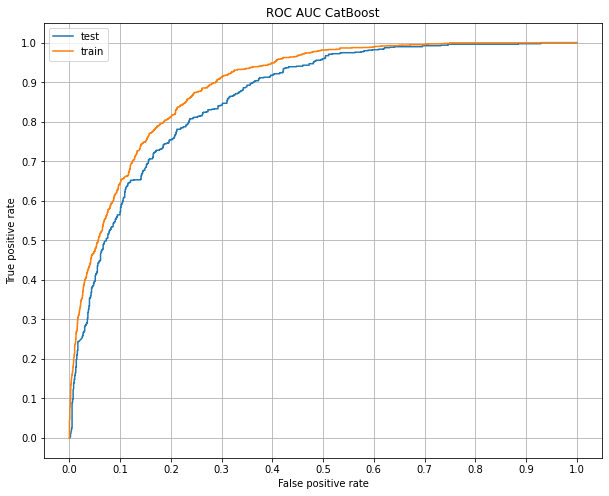

In [33]:
y_train_predicted = catboost.predict_proba(X_train)[:, 1]
y_test_predicted = catboost.predict_proba(X_val)[:, 1]

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(*roc_curve(y_val, y_test_predicted)[:2], label='test')
ax.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train')
ax.legend()
ax.set(xlabel='False positive rate', ylabel='True positive rate', title=f'ROC AUC CatBoost')
ax.grid()
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xticks(np.linspace(0, 1, 11));

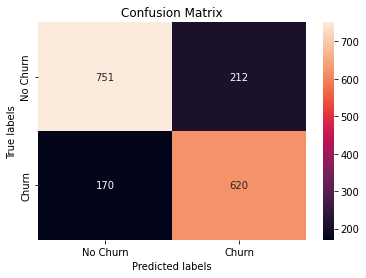

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix

y_test_predicted = catboost.predict(X_val)
cm = confusion_matrix(y_val, y_test_predicted)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

In [35]:
roc_auc_score(y_val, catboost.predict_proba(X_val)[:, 1])

0.8641994295253493

## Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

PARAMS = {
    "min_samples_split": [9],  # range(2, 200),
    "min_samples_leaf": [19],  # range(1, 200),
}
clf = RandomForestClassifier(n_estimators=200, random_state=42)

grid_search = GridSearchCV(clf, PARAMS, scoring="roc_auc", cv=5)
rf = grid_search.fit(X_train, y_train);

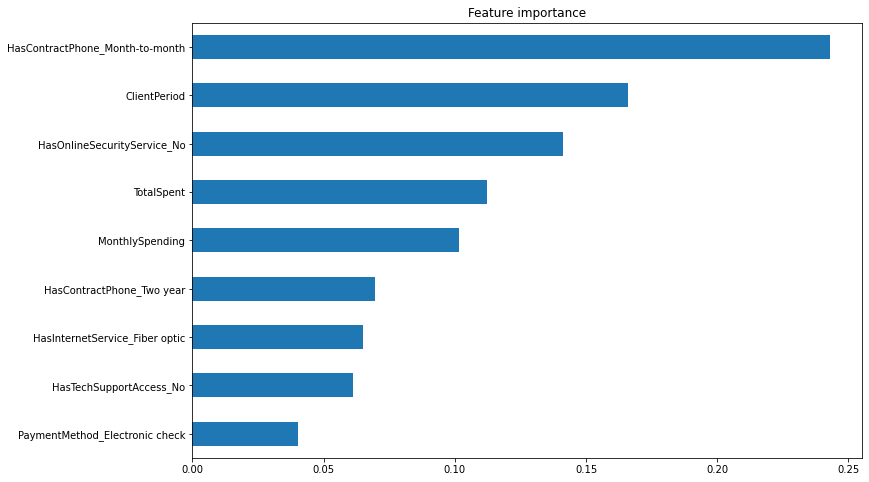

In [37]:
pd.DataFrame(rf.best_estimator_.feature_importances_, index=X_train.columns, columns=["importance"]) \
    .sort_values("importance") \
    .plot(kind="barh", legend=False, figsize=(12, 8));
plt.title("Feature importance");

In [38]:
print(f"Best score: {rf.best_score_}")
print(f"Best params: {rf.best_params_}")

Best score: 0.8642552857013819
Best params: {'min_samples_leaf': 19, 'min_samples_split': 9}


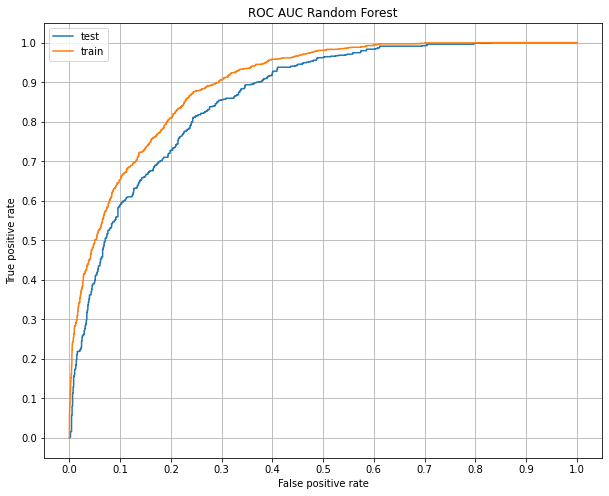

In [39]:
y_train_predicted = rf.predict_proba(X_train)[:, 1]
y_test_predicted = rf.predict_proba(X_val)[:, 1]

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(*roc_curve(y_val, y_test_predicted)[:2], label='test')
ax.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train')
ax.legend()
ax.set(xlabel='False positive rate', ylabel='True positive rate', title=f'ROC AUC Random Forest')
ax.grid()
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xticks(np.linspace(0, 1, 11));

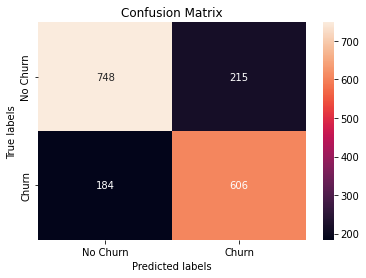

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt  
from sklearn.metrics import confusion_matrix

y_test_predicted = rf.predict(X_val)
cm = confusion_matrix(y_val, y_test_predicted)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

## Best model submition
Kaggle test score 0.85

In [41]:
test = pd.read_csv('Data-Mining-Project/data/test.csv')
test.TotalSpent = test.TotalSpent.replace(' ', 1) 
test.TotalSpent = test.TotalSpent.astype(float)
test.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.40,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.60,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


In [42]:
cat_cols = []
bin_cols = []
num_cols = []
for col in test.columns.tolist():
    if len(test[col].value_counts()) > 2 and len(test[col].value_counts())<10:
        cat_cols.append(col)
    elif len(test[col].value_counts()) == 2:
        bin_cols.append(col)
    else:
        num_cols.append(col)


encoder = LabelEncoder()
test[bin_cols] = test[bin_cols].apply(LabelEncoder().fit_transform)
test = pd.concat((test[bin_cols + num_cols], pd.get_dummies(test[cat_cols])), axis=1)


test[num_cols] = scaler.transform(test[num_cols])



In [48]:
feature_list = feature_list[:-1]

In [49]:
submission = pd.read_csv("Data-Mining-Project/data/submission.csv")
submission["Churn"] = catboost.predict_proba(test[feature_list])[:, 1]
submission.to_csv("Data-Mining-Project/data/catboost_sub.csv", index=False)